# Loan Repayment 
## Notebook 2: Exploratory Data Analysis (EDA)
<font size='3'>
This notebook will cover insights gained from exploring the transformed data. The important bits regarding data, assumptions made, and explanation made for each data transformation are covered in data_transform.ipynb. Therefore, this notebook will solely focus on creating visualizations and report findings. <b> It is highly recommended to go through data_transform.ipynb first </b> to understand the thought process of each decision made when processing the raw datasets.  
</font>

In [1]:
import os
# Change directory to this file's directory
this_path = globals()['_dh'][-1]
os.chdir(this_path)
print("This file's directory:", os.getcwd())
# Change current path to parent of this file's directory
# to access all modules from parent
os.chdir('..')
source_path = os.getcwd()
print("Parent directory:", source_path)

This file's directory: /home/mattkhoo/Git-Loan-Repayment-EDA-Predictive/notebooks
Parent directory: /home/mattkhoo/Git-Loan-Repayment-EDA-Predictive


In [2]:
from main.data_loader import DataLoader
from main import viz_utils as viz
%matplotlib inline

In [3]:
# Load feather data
os.chdir(source_path)
feather_path = os.path.join(str(os.getcwd()),'data-feathers') 
print('List of files at', feather_path)
for _, _, files in os.walk(feather_path):
    for file in files: print(file)

List of files at /home/mattkhoo/Git-Loan-Repayment-EDA-Predictive/data-feathers
clarity_underwriting_variables
payment
loan
transformed


In [4]:
# Load transformed data
data_manager = DataLoader()
load_path = os.path.join(feather_path, 'transformed')
data_manager.load_feather(load_path)
print("Shape of transformed data:", data_manager.data.shape)
data_manager.display_types()

Shape of transformed data: (30672, 15)


payFrequency                         object
apr                                 float64
nPaidOff                            float64
loanStatus                           object
loanAmount                          float64
originallyScheduledPaymentAmount    float64
state                                object
leadType                             object
leadCost                              int64
fpStatus                             object
hasCF                                 int64
applicationYear                       int64
paymentAmount                       float64
paidOff                                bool
clearfraudscore                     float64
dtype: object

In [5]:
# For plotting purposes, convert all categorical variables to dtype 'category'
data_manager.convert_dtype(origin='object', target='category')  # object (string) to category
data_manager.convert_dtype(origin='bool', target='category') # boolean to category
# Some are numeric, so have to list column name manually
to_cat = ['hasCF', 'applicationYear', 'nPaidOff']
data_manager.column_to_cat(to_cat)  # convert selected columns to 'category'
data_manager.display_types()


payFrequency                        category
apr                                  float64
nPaidOff                            category
loanStatus                          category
loanAmount                           float64
originallyScheduledPaymentAmount     float64
state                               category
leadType                            category
leadCost                               int64
fpStatus                            category
hasCF                               category
applicationYear                     category
paymentAmount                        float64
paidOff                             category
clearfraudscore                      float64
dtype: object

Text(0.5, 0.98, 'Distribution of Categorical variables')

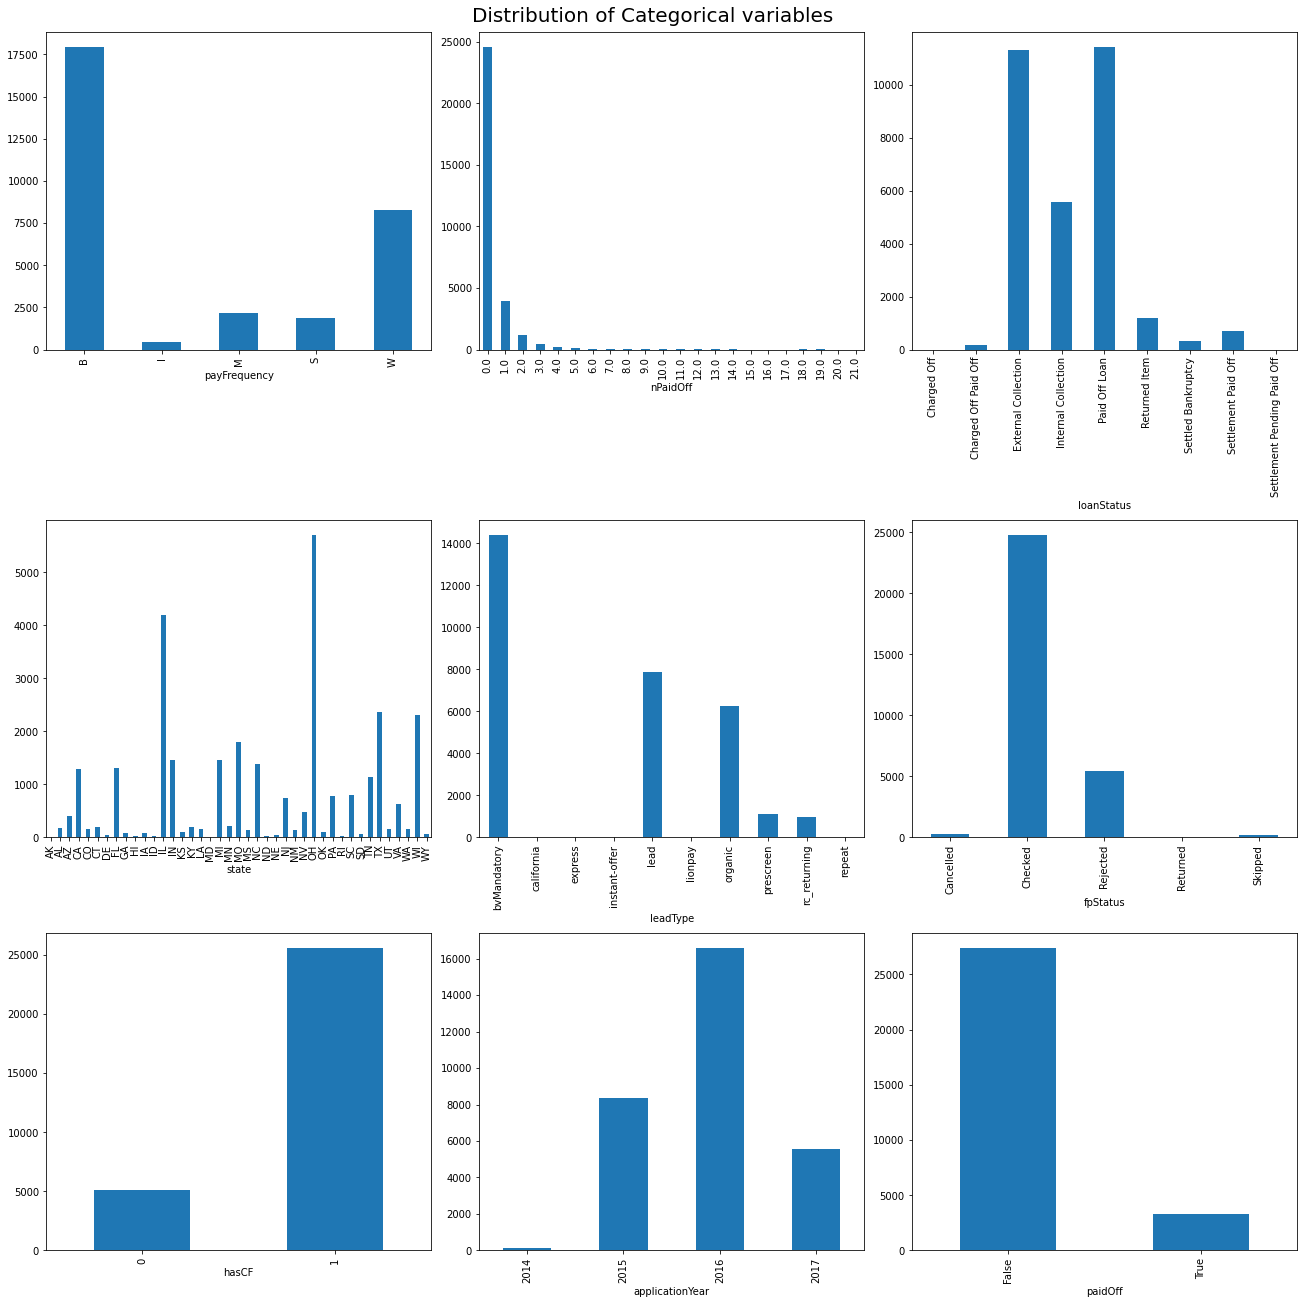

In [6]:
# For each categorical variable, Plot the count for each unique value
cols_unique_freq = data_manager.get_cols_unique_freq(datatype='category')
fig, axes = viz.bar_subplots(cols_unique_freq, subrow=3, figsize_ep=6)
fig.suptitle('Distribution of Categorical variables', fontsize=20)

In [7]:
# Plot historgram for each Continuous variable
